In [41]:
import pandas as pd
import numpy as np
import gc
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import scipy

In [42]:
warnings.filterwarnings('ignore')

In [43]:
# name of target variable
target = 'grades'
# list of date base features names
date_cols = ['month', 'day', 'year', 'day_of_week', 'hour', 'time_of_day', 'season']

In [5]:
# original data
train = pd.read_csv('train_ml.csv')
test = pd.read_csv('new_test_ml.csv', index_col='Unnamed: 0')

# preprocessed data
preprocessed_train = pd.read_csv("preprocessed_train.csv")
preprocessed_test = pd.read_csv("preprocessed_test.csv")

,bank,feeds,grades,date
0,ubrr,"Много лет являюсь клиентом этого банка, но пос...",1.0,16.02.2017 16:10
1,fk_otkritie,"Г. Ростов-на-Дону, ул. Ленина, 48. Были 10.12....",2.0,13.12.2016 1:05
2,alfabank,Здравствуйте!Ранее уже оставлял отзыв о вашем ...,NaN,28.06.2019 13:54
3,vtb,Обращаюсь к Вам с жалобой на незаконное списан...,NaN,15.07.2020 14:54
4,promsvyazbank,"Имею потребительский кредит, взятый в Связь-ба...",2.0,04.08.2020 6:38


In [6]:
# drop nans
train = train.dropna()

assert train.isna().sum().sum() == 0"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   bank    75000 non-null  object 
 1   feeds   75000 non-null  object 
 2   grades  51476 non-null  float64
 3   date    75000 non-null  object 
dtypes: float64(1), object(3)
memory usage: 2.3+ MB


In [7]:
# target
y_train = train[target]

,bank,feeds,grades,date
0,ubrr,"Много лет являюсь клиентом этого банка, но пос...",1,2017-02-16 16:10:00
1,fk_otkritie,"Г. Ростов-на-Дону, ул. Ленина, 48. Были 10.12....",2,2016-12-13 01:05:00
4,promsvyazbank,"Имею потребительский кредит, взятый в Связь-ба...",2,2020-08-04 06:38:00
7,homecreditbank,Хочу выразить глубокую благодарность всем сотр...,5,2015-04-19 20:11:00
8,vtb,"6 марта 2019г. В 10:33 при проходе в метро ""Ку...",2,2019-03-28 18:36:00
...,...,...,...,...
74995,trust,Три года длится эпопея с закрытием кредитной к...,1,2016-10-26 11:03:00
74996,fk_otkritie,"Являлся клиентом Бинбанка, пока после слияния ...",2,2020-02-01 21:07:00
74997,sberbank,8 мая 2016 г. мною вносились деньги на банковс...,1,2016-06-14 16:03:00
74998,uralsib,Здравствуйте! Сегодня 21.04.2020 захожу в моби...,3,2020-04-21 08:24:00


In [8]:
# log the text_len and num_words features

preprocessed_train[['text_len', 'num_words']] = np.log(preprocessed_train[['text_len', 'num_words']])
preprocessed_test[['text_len', 'num_words']] = np.log(preprocessed_test[['text_len', 'num_words']])

sberbank        8355
vtb             5255
tcs             4503
sovcombank      2600
fk_otkritie     2599
                ... 
sdm-bank          33
primsotsbank      31
intesa            31
rncb              30
rnbank            26
Name: bank, Length: 69, dtype: int64

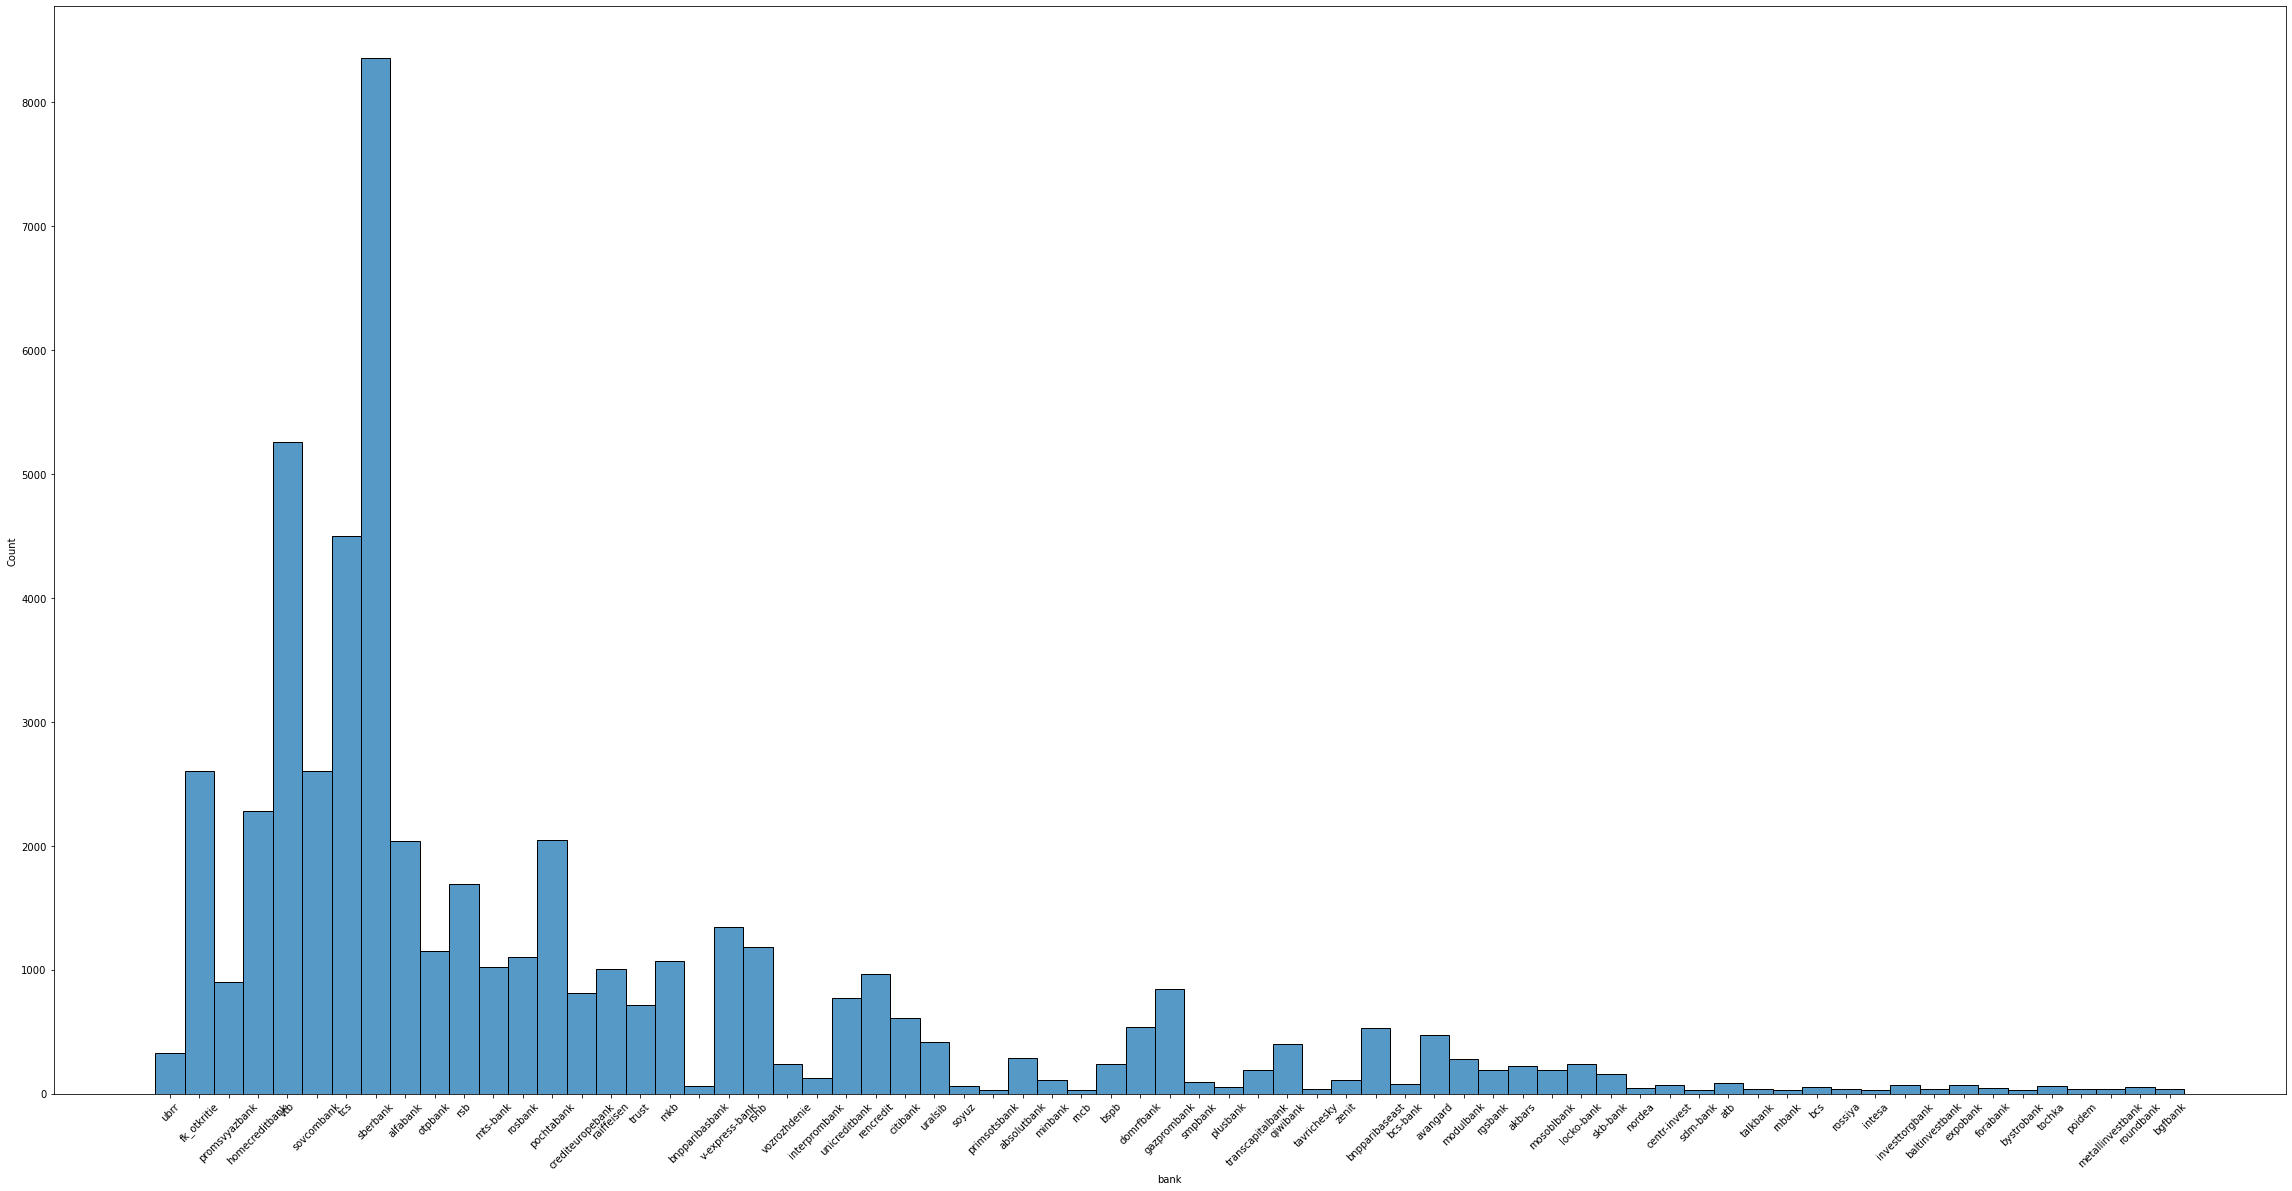

In [9]:
# date feature dtype -> datetime

train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [10]:
def extract_date_features(data: pd.DataFrame, date_col: str):
    """
    The function extracts date based features from datetime feature

    :param data: pd.DataFrame extract features to
    :param date_col: str name datetime columns
    :return: pd.DataFrame with new features
    """
    data['month'] = data[date_col].dt.month
    data['day'] = data[date_col].dt.day
    data['year'] = data[date_col].dt.year
    data['day_of_week'] = data[date_col].dt.day_of_week
    data['hour'] = data[date_col].dt.hour
    # create time of day feature
    # 1 - 12am-05am, 2 - 06am-11am, 3 - 12pm-5pm, 4 - 6pm-11pm
    time_of_day = [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
                   3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4]
    hour_to_time_of_day = dict(zip(range(0, 24), time_of_day))
    data['time_of_day'] = data['hour'].map(hour_to_time_of_day)
    # create season feature
    # 1 - winter, 2 - spring, 3 - summer, 4 - autumn
    seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]
    month_to_season = dict(zip(range(1, 13), seasons))
    data['season'] = data['month'].map(month_to_season)

    return data

1    27739
2     5634
3     2356
4     1520
5    14227
Name: grades, dtype: int64

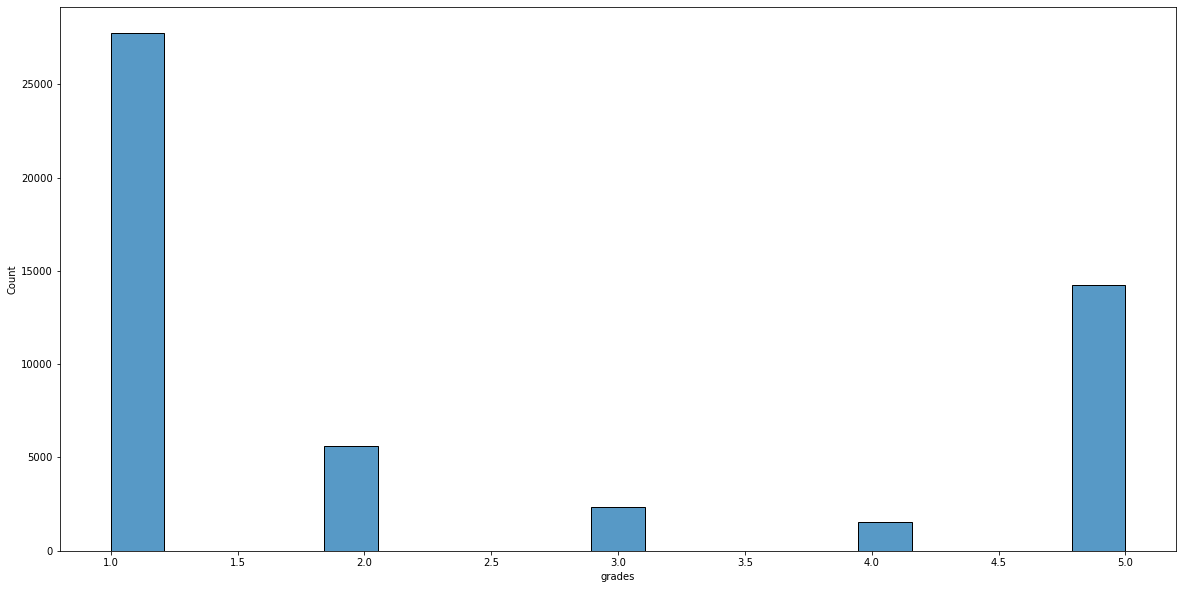

In [11]:
# extract date features

train = extract_date_features(data=train, date_col='date')
test = extract_date_features(data=test, date_col='date')

In [12]:
# concat text_len & num_words with date based features

train_num = pd.concat([preprocessed_train[['text_len', 'num_words']].reset_index(drop=True),
                       train[date_cols].reset_index(drop=True)], axis=1).astype('float32')
test_num = pd.concat([preprocessed_test[['text_len', 'num_words']].reset_index(drop=True),
                      test[date_cols].reset_index(drop=True)], axis=1).astype('float32')

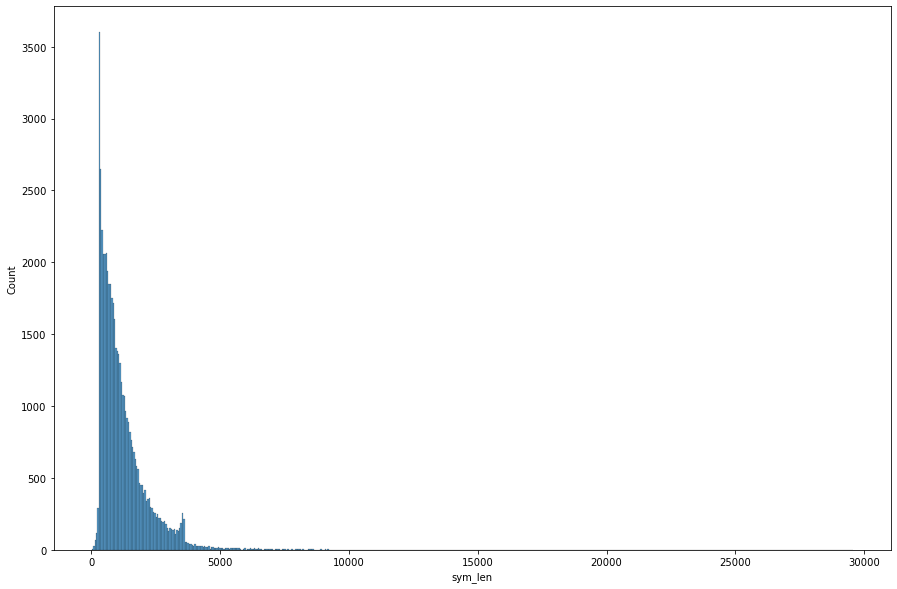

In [13]:
# create sparse matriсes from numerical features

train_num = scipy.sparse.csr_matrix(train_num.values)
test_num = scipy.sparse.csr_matrix(test_num.values)

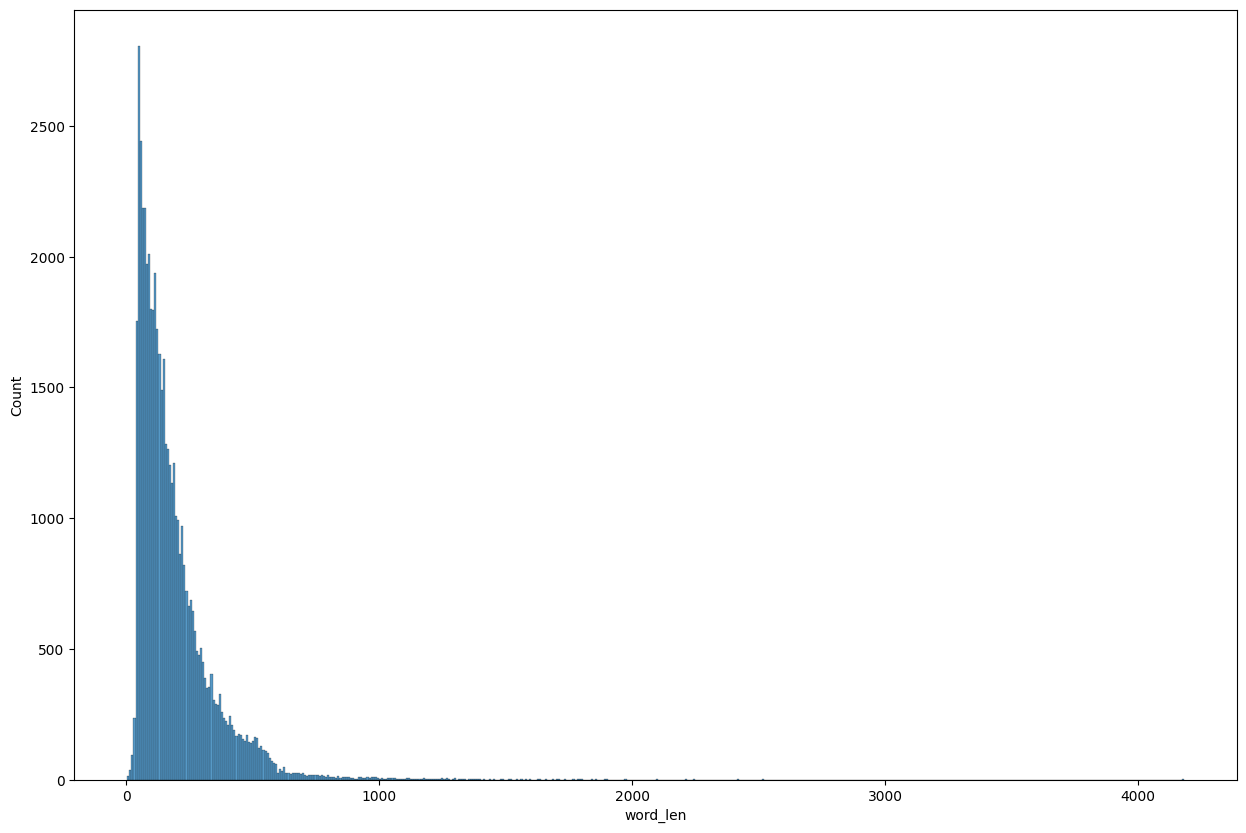

In [21]:
# tfidf transformation of text data

vec = TfidfVectorizer(min_df=3, max_features=None,
                      strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
                      ngram_range=(1, 3), use_idf=1, smooth_idf=1, sublinear_tf=1)

bow_train_old = vec.fit_transform(preprocessed_train['lemmas'])
bow_test_old = vec.transform(preprocessed_test['lemmas'])

In [14]:
# CountVectorizer transformation of text data

cv = CountVectorizer()

train_cv = cv.fit_transform(preprocessed_train['lemmas'])
test_cv = cv.transform(preprocessed_test['lemmas'])

In [15]:
# CountVectorizer with ngram transformation

ngram_cv = CountVectorizer(ngram_range=(1, 2))

train_ngram_cv = ngram_cv.fit_transform(preprocessed_train['lemmas'])
test_ngram_cv = ngram_cv.transform(preprocessed_test['lemmas'])

((27474, 6), (51476, 6))

In [16]:
# tf idf
full_train_bow = scipy.sparse.hstack([bow_train_old, train_num]).tocsr()
full_test_bow = scipy.sparse.hstack([bow_test_old, test_num]).tocsr()

# countvectorizer
full_train_cv = scipy.sparse.hstack([train_cv, train_num]).tocsr()
full_test_cv = scipy.sparse.hstack([test_cv, test_num]).tocsr()

# count vectorizer with ngram
full_train_ngram = scipy.sparse.hstack([train_ngram_cv, train_num]).tocsr()
full_test_ngram = scipy.sparse.hstack([test_ngram_cv, test_num]).tocsr()

Writing preproces_text.py


In [17]:
del train, test, preprocessed_test, preprocessed_train, bow_test_old, bow_train_old, \
    train_cv, test_cv, train_ngram_cv, test_ngram_cv, train_num, test_num

gc.collect()

In [18]:
from lightgbm import LGBMClassifier

100%|██████████| 51476/51476 [09:48<00:00, 87.49it/s] 


,bank,feeds,grades,date,sym_len,word_len,lemmas
13059,crediteuropebank,Доброго времени суток. Хотелось бы понять один...,2,2014-06-16 21:17:00,831,123,добрый время сутки хотеться понять момент имен...
52081,pochtabank,"Самый худший банк, в котом когда-либо обслужив...",1,2020-07-11 16:50:00,1153,172,самый плохой банк либо обслуживаться подать за...
45837,vozrozhdenie,"Речь пойдёт о Волжском филиале Банка ""Возрожде...",5,2006-10-24 09:25:00,1415,205,речь пойда волжский филиал банк возрождение во...
65334,vtb,Я с мужем получаем зарплату на карту ВТБ с мая...,1,2018-03-27 09:37:00,483,73,получать зарплата карта недавно хотеть взять п...
69729,pochtabank,Получила предложение оформить кредитную карту ...,5,2016-08-05 14:26:00,578,80,получить предложение оформить кредитный карта ...


In [19]:
lgbm_params = {
    'n_estimators': 2000,
    'early_stopping_rounds': 100,
    'boosting_type': 'dart',
    'max_depth': 8,
    'random_state': 42,
    'bagging_fraction': 0.5,
    'feature_fraction': 0.5,
    'num_class': 5
}

,bank,feeds,grades,date,sym_len,word_len
7,homecreditbank,Хочу выразить глубокую благодарность всем сотр...,5,2015-04-19 20:11:00,438,53
12,sovcombank,04.03.2021 г в офисе совкомбанка снимала собст...,2,2021-03-23 11:16:00,638,94
19,otpbank,На днях обратился в офис банка по адресу Дикоп...,5,2021-02-17 15:56:00,320,49
22,tcs,"Ценю сотрудничество с банком Тинькофф, посколь...",5,2020-10-19 20:35:00,314,41
23,alfabank,"Здравствуйте, являюсь клиентов Альфа банка уже...",2,2020-04-10 12:59:00,764,116


In [20]:
%%time

model = LGBMClassifier(**lgbm_params)

model.fit(full_train_bow, y_train)

False

In [21]:
%%time

model_cv = LGBMClassifier(**lgbm_params)

model_cv.fit(full_train_cv, y_train)

<ipython-input-21-1747646f7cb4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['bank'] = enc.transform(new_df['bank']) + 1


,bank,feeds,grades,date,sym_len,word_len
7,22,Хочу выразить глубокую благодарность всем сотр...,5,2015-04-19 20:11:00,438,53
12,55,04.03.2021 г в офисе совкомбанка снимала собст...,2,2021-03-23 11:16:00,638,94
19,34,На днях обратился в офис банка по адресу Дикоп...,5,2021-02-17 15:56:00,320,49
22,59,"Ценю сотрудничество с банком Тинькофф, посколь...",5,2020-10-19 20:35:00,314,41
23,3,"Здравствуйте, являюсь клиентов Альфа банка уже...",2,2020-04-10 12:59:00,764,116


In [22]:
%%time

model_ngram = LGBMClassifier(**lgbm_params)

model_ngram.fit(full_train_ngram, y_train)

In [23]:
# predict

p = model_ngram.predict_proba(full_test_ngram) + model_cv.predict_proba(full_test_cv) + model.predict_proba(full_test_bow)

In [24]:
# create dataframe from predictions

preds = pd.DataFrame(p, columns=[1, 2, 3, 4, 5]).idxmax(axis=1).reset_index().rename(columns={'index': 'inds', 0: 'grades'})

<ipython-input-23-20c96f1d49c5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['feeds'] = df['feeds'].str.lower()
<ipython-input-23-20c96f1d49c5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['feeds'] = df['feeds'].apply(remove_stopwords)
<ipython-input-23-20c96f1d49c5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [25]:
preds['grades'].value_counts()

,bank,feeds,grades,date,sym_len,word_len
7,22,хотеть выразить глубокий благодарность весь со...,5,2015-04-19 20:11:00,438,53
12,55,г офис совкомбанк снимать собственный средст...,2,2021-03-23 11:16:00,638,94
19,34,день обратиться офис банк адрес дикопольцев да...,5,2021-02-17 15:56:00,320,49
22,59,ценить сотрудничество банк тинькофф поскольк...,5,2020-10-19 20:35:00,314,41
23,3,здравствуйте являться клиент альфа банк пара...,2,2020-04-10 12:59:00,764,116


In [26]:
preds.to_csv('submission_13.csv', index=False)

CPU times: user 4.76 s, sys: 416 ms, total: 5.17 s
Wall time: 5.25 s


In [40]:
sol.to_csv('new_baseline.csv', index=False)